In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pathlib
import time
import datetime
import os
import numpy as np
import random
from PIL import Image
Image.MAX_IMAGE_PIXELS = 1177989684
import tensorflow as tf
from IPython import display

# Pix2pix tensorflow tutorial

## Load dataset

In [4]:
train_dataset = tf.data.Dataset.load('tf_dataset/train_dataset_512')
trest_dataset = tf.data.Dataset.load('tf_dataset/test_dataset_512')

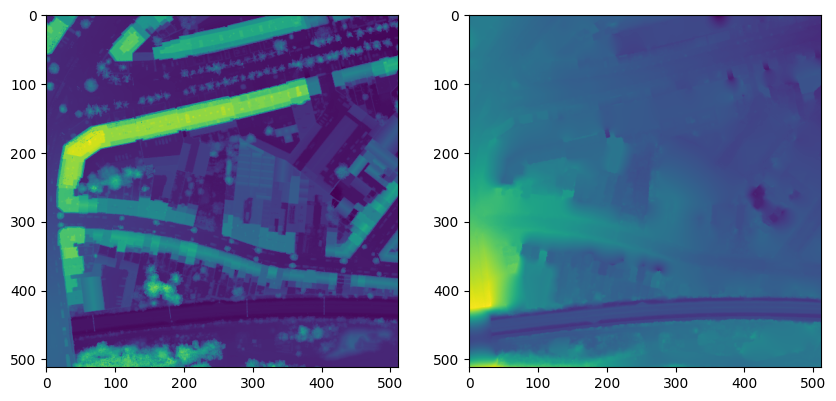

In [20]:
example = [item for item in train_dataset.take(1)]
inp, re = example[0][0], example[0][1]
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(inp[0])
plt.subplot(1,2,2)
plt.imshow(re[0])

In [29]:
inp = tf.reshape(inp, (512,512,1))

In [30]:
inp

<tf.Tensor: shape=(512, 512, 1), dtype=float32, numpy=
array([[[0.506453  ],
        [0.50605714],
        [0.5221491 ],
        ...,
        [0.56392   ],
        [0.5608765 ],
        [0.56425166]],

       [[0.5064752 ],
        [0.5062746 ],
        [0.52008635],
        ...,
        [0.57425   ],
        [0.57027584],
        [0.5651305 ]],

       [[0.50689137],
        [0.5066401 ],
        [0.523468  ],
        ...,
        [0.573739  ],
        [0.57491004],
        [0.55786204]],

       ...,

       [[0.6182748 ],
        [0.618573  ],
        [0.6186316 ],
        ...,
        [0.505617  ],
        [0.5050905 ],
        [0.50469583]],

       [[0.61798024],
        [0.6186945 ],
        [0.6196619 ],
        ...,
        [0.5055419 ],
        [0.5055504 ],
        [0.50521666]],

       [[0.61797196],
        [0.6187288 ],
        [0.62046474],
        ...,
        [0.5061645 ],
        [0.50599253],
        [0.5053545 ]]], dtype=float32)>

## Build generator

In [25]:
OUTPUT_CHANNELS = 1


def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result


down_model = downsample(1, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)


(1, 256, 256, 1)


In [ ]:
inp.shape

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

up_model = upsample(1, 4)
up_result = up_model(down_result)

print (up_result.shape)


In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[512, 512, 1])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
    downsample(1024, 4)
  ]

  up_stack = [
      
    upsample(1024, 4, apply_dropout=True) , 
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]


  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


In [ ]:
generator = Generator()
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

## Generator loss

In [ ]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

## Discriminator

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[512, 512, 1], name='input_image')
  tar = tf.keras.layers.Input(shape=[512, 512, 1], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)
  down4 = downsample(512, 4)(down3)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(1024, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)


In [ ]:
discriminator = Discriminator()
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()


### Discriminator loss

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

### Optimizers and checkpoints

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


### Generate images

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()


In [ ]:
for example_input, example_target in test_dataset.take(3):
  generate_images(generator, example_input, example_target)


## Training

In [ ]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


In [ ]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)


In [ ]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)


In [ ]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

In [ ]:
fit(train_dataset, test_dataset, steps=50001)

In [ ]:
generate_images(generator, example_input, example_target)

In [ ]:
ls {checkpoint_dir}

In [ ]:
# Restoring the latest checkpoint in checkpoint_dir
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
train_dataset.save('dataset512/saved_DS')

In [ ]:
start = time.time()
loaded_train_dataset = tf.data.Dataset.load('dataset512/saved_DS')
print(str(time.time()-start) + ' s')
loaded_train_dataset

In [ ]:
for inp, tar in loaded_train_dataset.take(2):
    plt.figure(figsize=(15, 15))
    plt.subplot(1,2,1)
    plt.imshow(inp[0])
    plt.subplot(1,2,2)
    plt.imshow(tar[0])